<a href="https://colab.research.google.com/github/Mingyuli1996/Stock-Price-Estimation/blob/master/Stock_Price_multi_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pykalman

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
from datetime import datetime, timedelta
from pykalman import KalmanFilter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
%matplotlib inline

In [0]:
def reduce_noise(X):
#This function applys kalman filter to reduce the noise in daily stock price
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = X.values[0],
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)
    
    state_means,_ = kf.filter(X.values)
    state_means = state_means.flatten()
#     state_means=state_means.astype(int)
    return state_means

def get_prices(ticks, st, ed):
# This function gets Adjusted Closing prices from Yahoo Finance
# returns a DataFrame. Inputs are ticks (list of tickers), st (start date), ed (end date)
    for idx, ticker in enumerate(ticks):
        print(ticker)
        f = web.DataReader(ticker, 'yahoo', st, ed)['Adj Close']
        f.name = ticker
        if idx==0:
            df = f
        else:
            df = pd.concat([df, f], axis=1)
        return df

In [0]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#get the data
start = dt.datetime(2009, 5, 1)
end   = dt.datetime.today()

tickers = [['IBM']]
df = get_prices(tickers, start, end)
df.head()


In [0]:
# df = web.DataReader('IBM' , 'yahoo', start, end)
df_clean=reduce_noise(df['Adj Close'])
df_clean2=pd.DataFrame(data=df_clean,index = df.index.values,columns=['Close'])
#print the head

Text(0.5, 1.0, 'Price Trend from 2009 to 2019')

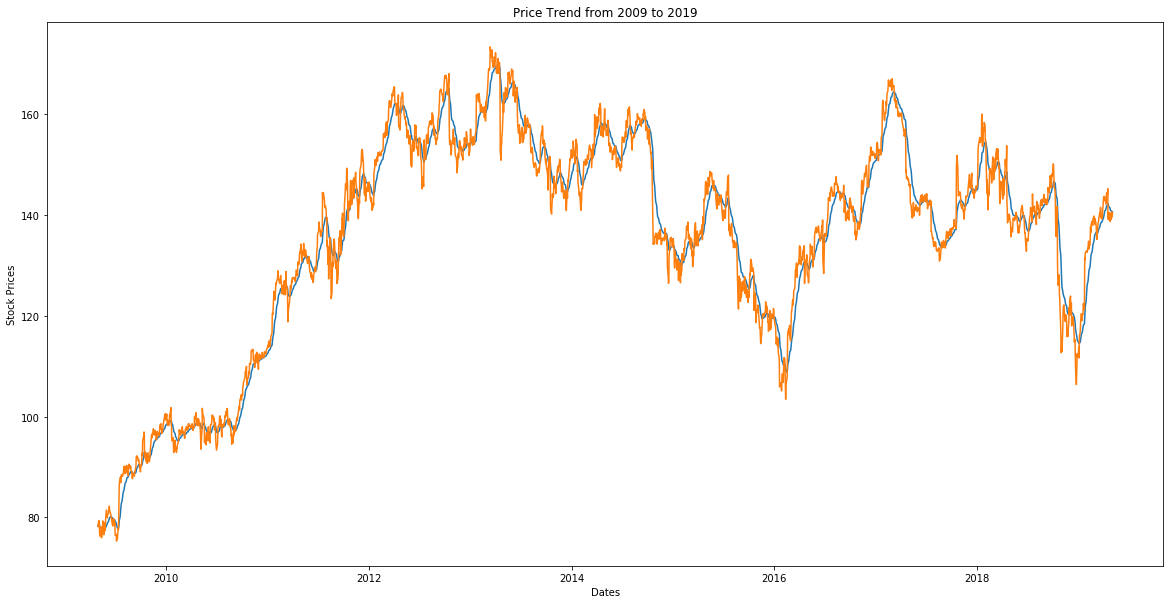

In [0]:
# plt.figure(figsize=(16,8))
# ax = df_clean2.rename(columns={"Close": "Denoised_price"}).plot(title='Random Forest predicted prices 8-2 years')


plt.plot(df_clean2['Close'])
plt.plot(df['Adj Close'])

# fig = df.rename(columns={"Adj Close": "Actual_price"}).plot(ax = ax).get_figure()

plt.xlabel("Dates")
plt.ylabel("Stock Prices")
plt.title('Price Trend from 2009 to 2019')

In [0]:
df_clean2['Date']=df.index

In [0]:
data = df_clean2.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values


In [0]:
dataset 

array([[78.22901153564453],
       [78.62807777859517],
       [78.7643694942996],
       ...,
       [140.65201925187878],
       [140.55099440505265],
       [140.52236233575786]], dtype=object)

In [0]:
train_start_date = '2009-05-01'
train_end_date = '2017-04-30'
test_start_date = '2017-05-01'
test_end_date = '2019-05-03'
train = df.ix[train_start_date : train_end_date]
test= df.ix[test_start_date:test_end_date]
print(train.shape,valid.shape)

(2013, 6) (506, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [0]:
train = dataset[0:2013,:]
test = dataset[2013:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
x_train, y_train = [], []
# for i in range(60,len(train)):
#     x_train.append(scaled_data[i-60:i,0])
#     y_train.append(scaled_data[i,0])
#     x_train, y_train = np.array(x_train), np.array(y_train)

for i in range(0,len(train)):
    x_train=np.append(x_train,scaled_data[i,0])
    y_train=np.append(y_train,scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

In [0]:
x_train = np.reshape(x_train, (x_train.shape[0],1,1))

In [0]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1,1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
 - 8s - loss: 0.0086
Epoch 2/20
 - 6s - loss: 2.0540e-05
Epoch 3/20
 - 6s - loss: 4.2953e-06
Epoch 4/20
 - 7s - loss: 1.3069e-05
Epoch 5/20
 - 6s - loss: 1.5387e-05
Epoch 6/20
 - 6s - loss: 1.2136e-05
Epoch 7/20
 - 6s - loss: 1.7455e-05
Epoch 8/20
 - 6s - loss: 2.4090e-05
Epoch 9/20
 - 6s - loss: 1.6226e-05
Epoch 10/20
 - 6s - loss: 1.3778e-05
Epoch 11/20
 - 6s - loss: 1.1680e-05
Epoch 12/20
 - 6s - loss: 1.2885e-05
Epoch 13/20
 - 6s - loss: 1.8110e-05
Epoch 14/20
 - 6s - loss: 1.5689e-05
Epoch 15/20
 - 6s - loss: 1.6730e-05
Epoch 16/20
 - 6s - loss: 1.3106e-05
Epoch 17/20
 - 6s - loss: 1.5704e-05
Epoch 18/20
 - 6s - loss: 1.2881e-05
Epoch 19/20
 - 6s - loss: 1.6187e-05
Epoch 20/20
 - 6s - loss: 1.8448e-05


In [0]:

inputs = new_data[len(new_data) - len(test) :].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(0,inputs.shape[0]):
    X_test=np.append(X_test,inputs[i,0])
    X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],1,1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [0]:
rms=np.sqrt(np.mean(np.power((test-closing_price),2)))
rms

Adj Close         NaN
Close        7.650958
High              NaN
Low               NaN
Open              NaN
Volume            NaN
dtype: float64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


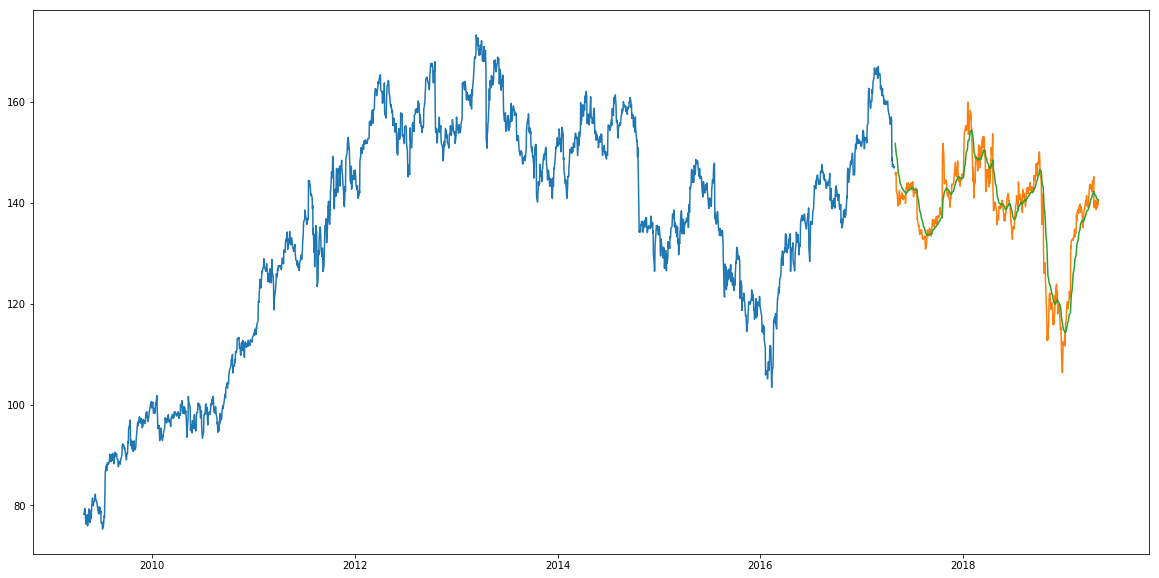

In [0]:
#Compare the estimation with the test dataset
train_end_date = '2017-04-30'
test_start_date = '2017-05-01'
test_end_date = '2019-05-03'
train = df.ix[train_start_date : train_end_date]
test = df.ix[test_start_date:test_end_date]

# plt.plot(train['Adj Close'])
plt.plot(train['Adj Close'])

plt.plot(test['Adj Close'])

closing_price=pd.DataFrame(data=closing_price,index = test.index.values,columns=['Close'])
plt.plot(closing_price['Close'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


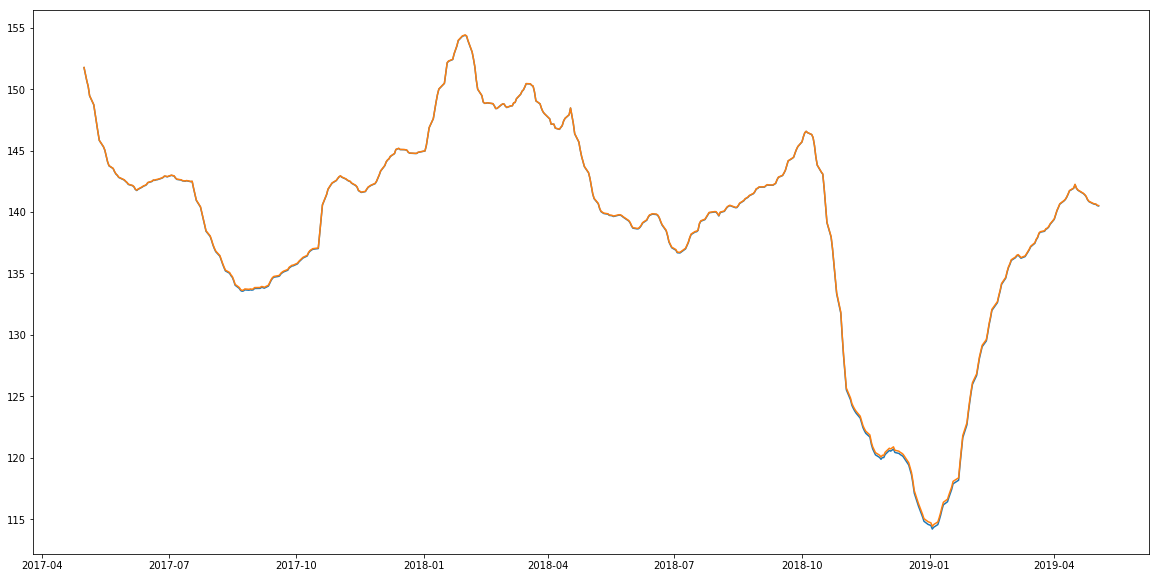

In [0]:
#Compare the estimation with the denoised stock price
plt.plot(closing_price['Close'])
plt.plot(df_clean2.ix[test_start_date:test_end_date]['Close'])